# Eigenfaces: Dimensionality Reduction and PCA

[Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) is the name given to a set of eigenvectors (principal components) when they are used in the computer vision problem of human face recognition. These eigenvectors/principal components can be derived from the covariance matrix of $X$, where $X$ is a $d$ x $n$ matrix such that each column of $X$ represents an image. (One of the ways of interpreting PCA is projecting data onto the $k$ leading eigenvectors of the sample covariance matrix)

### Load Image Data(sub)set

The numpy array is loaded with a subset of the [LFW Face Database](http://vis-www.cs.umass.edu/lfw/)\[1\]. It is of shape 75 x 250 x 250, representing 75 images of faces of celebrities. The mean face, i.e. the average of the 75 images, is computed and visualized.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# read in the dataset
images_orig = np.load('lfw_funneled_subset.npy')
height, width = images_orig[0, ...].shape

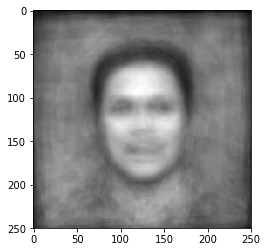

In [3]:
# calculate mean
mean = images_orig.sum(axis=0) / images_orig.shape[0]
plt.imshow(mean, cmap='gray')
plt.show()

### Reshaping 
The matrix is reshapes to shape 62500 x 75 so that each column is a "flattened" representation of an image. This is the $X$ matrix as described above.

In [4]:
images_orig.shape

(75, 250, 250)

In [5]:
# reshape so that each image is a column vector
images_orig = images_orig.reshape(images_orig.shape[0], -1).transpose()

In [7]:
images_orig.shape

(62500, 75)

### Eigenface Calculation

One way of finding principal components/eigenfaces is by finding top eigenvectors of the sample covariance matrix of $X$. However, this is often computationally infeasible because of the large size of the covariance matrix. Therefore, the following [math trick](https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors) is used to compute the eigenvectors and eigenvalues : the eigenvectors and eigenvalues of $X \cdot X^T$ can be obtained by finding eigenvectors and eigenvalues of $X^T \cdot X$ first, and then pre-multiply these eigenvectors by $X$. This is more "doable" since $X^T \cdot X$ has dimensions 75 x 75 whereas $X \cdot X^T$ had dimensions 62500 x 62500. Using this trick, the top 60 eigenfaces will be calculated for the given data.

In [9]:
# number of images in dataset
num_samples = images_orig.shape[1]
num_vecs = 60

# mean vector
mean_vec = images_orig.mean(axis=1, keepdims=True)

# mean center the dataset
images = images_orig - mean_vec

# calculate patternwise covariance matrix
M = images.T @ images

# get eigenvalues and eigenvectors for L
eigenvalues, eigenvectors = np.linalg.eig(M)

# sort eigenvectors according to corresponding eigenvalues (in decreasing order)
decr_sorted_eval_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[decr_sorted_eval_idx]
eigenvectors = eigenvectors[:, decr_sorted_eval_idx]

# convert the eigenvectors of A' * A into eigenvectors of A * A'
eigenvectors = images @ eigenvectors

# normalize eigenvalues they are specifically for cov(A), not A * A'
eigenvalues /= num_samples

# normalize vectors to unit length
eigenvectors /= np.linalg.norm(eigenvectors, axis=0, keepdims=True)

# top num_vecs eigenvalues and eigenvectors
#print(eigenvalues[:num_vecs], eigenvectors[:, :num_vecs], mean_vec) 

### Eigenvalue Visualization

Below is a plot of the top 60 eigenvalues computed corresponding to the top 60 eigenfaces. (eigenvalue # on x-axis, eigenvalue on y-axis)

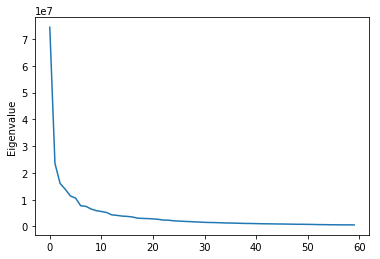

In [10]:
plt.plot(eigenvalues[:num_vecs])
plt.ylabel('Eigenvalue')
plt.show()

### Projection and Reconstruction
An image $A$ can be represented in the space spanned by the top $k$ eigenvectors/principal components as follows:
$$P = C^T \cdot (A - \mu) \\ \text{where } P \text{ is } k \text{ x } 1 \text{ projection}
\\ \mu \text{ is } d \text{ x } 1 \text{ mean image vector}
\\ C \text{ is } d \text{ x } k \text{ matrix of k eigenvectors}$$

The projection $P$ can be used to reconstruct $A$ using the top $k$ eigenvectors/principal components follows:
$$R = C \cdot P + \mu \\ \text{where } R \text{ is } d \text{ x } 1 \text{ reconstruction}
\\ P \text{ is } k \text{ x } 1 \text{ projection}
\\ \mu \text{ is } d \text{ x } 1 \text{ mean image vector}
\\ C \text{ is } d \text{ x } k \text{ matrix of k eigenvectors}$$

Three images will be randomly selected from the $X$ matrix. For each image, I  will calculate its representation/projection in the space spanned by
1. top 10 eigenfaces
2. top 20 eigenfaces
3. top 30 eigenfaces
4. top 40 eigenfaces
5. top 50 eigenfaces
6. top 60 eigenfaces

In total, I will have computed 18 projections, 6 for each image.

Finally, from each projection, I will reconstruct the original image. I will display the original images and the reconstructed images (not the projections).

In total, I will have computed 18 reconstructions, 1 from each projection.

In [11]:
images_orig.shape

(62500, 75)

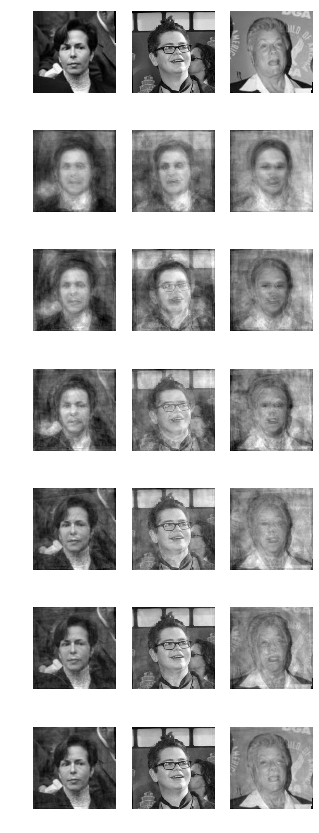

In [13]:
n_images = 3
images_idx = np.random.choice(images_orig.shape[1], n_images, replace=False)

# figure for plotting the 1 original + 6 reconstructions for n_images images
fig, ax = plt.subplots(7, n_images, figsize=(5, 15))

for i, idx in enumerate(images_idx):
    # get original image and its reconstruction using 10, 20, 30, 40, 50, 60 eigenfaces
    image = images_orig[:, idx]
    image = image.reshape(-1, 1)

    #original image
    ax[0][i].imshow(image.reshape(height, width), cmap="gray")
    ax[0][i].axis('off')
    
    # project and reconstruct
    for ci, num_comps in enumerate(range(10, 61, 10)):
        proj = eigenvectors[:, :num_comps].T @ (image - mean_vec)
        reconstruct = eigenvectors[:, :num_comps] @ proj + mean_vec
        reconstruct = reconstruct.reshape(height, width)

        ax[ci+1][i].imshow(reconstruct, cmap="gray")
        ax[ci+1][i].axis('off')

plt.show()

## Problem 3: Predicting Parkinson's

In this problem, we will be applying PCA to the [Parkinson's Disease Classification dataset](http://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification)\[2\] and then performing classification using the k nearest neighbors algorithm. For this problem, please use functions from the scikit-learn library ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [KNearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), etc) 

**a. Prepare and Pre-process** Load the data `pd_speech_X.csv` and corresponding labels `pd_speech_Y.csv`. Normalize the data by subtracting mean and dividing by variance for each attribute/feature. Split the data and labels into training and testing sets using train/test ratio of 0.8/0.2

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# load data
X_df = pd.read_csv("pd_speech_X.csv")
Y = pd.read_csv("pd_speech_Y.csv")
X_df.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,7.8832,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164


In [15]:
X_norm = X_df - np.mean(X_df, axis=0)
X_norm /= np.var(X_norm, axis=0)
X_norm.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,1.938462,3.709884,3.676434,4.410836,-0.008541,-0.008480,511.351426,-560.051414,-20.939710,1653.542049,...,-0.010206,-0.013861,-0.018998,-0.022600,-0.024075,-0.022470,-0.029670,-0.049334,-0.056486,-0.010717
1,1.938462,0.718870,-1.154458,2.682279,-0.009152,-0.009088,569.802731,-585.960451,-54.286307,-1210.267732,...,-0.010203,-0.013862,-0.018089,0.007566,0.000808,-0.003777,-0.010751,-0.033519,-0.040418,0.011705
2,1.938462,3.652586,-5.021231,5.341108,-0.009355,-0.009291,594.216925,-609.978317,-81.833497,-3883.156860,...,-0.010209,-0.013859,-0.019293,-0.013960,-0.007790,-0.003803,-0.028380,-0.048120,-0.055770,-0.022829
3,-2.065574,-11.706712,19.839835,5.486877,-0.014848,-0.014763,1350.093100,-378.614399,270.480555,54920.403960,...,-0.007361,-0.012615,-0.018130,-0.020470,0.000419,-0.025315,-0.028833,-0.040318,-0.040794,-0.023432
4,-2.065574,-14.617369,20.066444,2.185074,-0.008948,-0.008885,540.781495,4323.070175,438.663395,51483.832224,...,-0.006886,-0.011271,-0.015990,-0.019204,-0.020209,-0.014049,-0.002573,-0.026690,-0.046606,-0.021675


In [16]:
#split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2)
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)

(604, 753)
(604, 1)
(152, 753)


**b.** Using the train data and labels, train a k nearest neighbors classifier with k=3. Report the correct classification rate on the test data.

In [17]:
# apply knn
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, Y_train)

# test the model
y_pred_test = neigh.predict(X_test)

ccr_test = (y_pred_test == Y_test['class']).mean()
print('Test ccr = {:.5f}'.format(ccr_test))

Test ccr = 0.65789


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


**b.** Apply PCA (use number of components = 5) to the train data. Next, transform the train data to its representation in the lower dimensional space learned by the PCA model. Using this representation, train a k nearest neighbors classifier with k=3. Report the correct classification rate on the test data.

In [18]:
# pca using 5 components
pca = PCA(n_components=5)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
# apply knn on transformed data
neigh_pca = KNeighborsClassifier(n_neighbors=3)
neigh_pca.fit(pca.transform(X_train), Y_train['class'])

# test the model
y_pred_test = neigh_pca.predict(pca.transform(X_test))
ccr_test = (y_pred_test == Y_test['class']).mean()
print('Test ccr = {:.5f}'.format(ccr_test))

Test ccr = 0.67763


## Citations
1. Gary B. Huang, Vidit Jain, and Erik Learned-Miller. Unsupervised joint alignment of complex images. International Conference on Computer Vision (ICCV), 2007.
2. Sakar, C.O., Serbes, G., Gunduz, A., Tunc, H.C., Nizam, H., Sakar, B.E., Tutuncu, M., Aydin, T., Isenkul, M.E. and Apaydin, H., 2018. A comparative analysis of speech signal processing algorithms for Parkinsonâ€™s disease classification and the use of the tunable Q-factor wavelet transform. Applied Soft Computing, DOI